# Sgr Cleaning

Lay out the Sagittarius cleaning procedure.

This also has checks on the sample for contaminants based on velocities.

In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize
from exptool.basis import spheresl
from exptool.basis import eof

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2



mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

from exptool.utils import *


stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True




# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u



In [2]:

def norm_histogram(arr,bins=-1):
    
    if bins == -1:
        bins = int(len(arr)/100.)
        
    a = np.percentile(arr,0.0)
    A = np.percentile(arr,99.9)
    binvals = np.linspace(a,A,bins)
    outvals = np.zeros(binvals.size)
    #print(a,A,bins)
    da = (A-a)/(bins)
    
    for val in arr:
        #print(val-a,(val-a)/(da))
        indx = (val-a)/da
        if indx>bins-1: indx=bins-1
        #print(indx)
        outvals[int(indx)] += 1
        
    return binvals,outvals/(len(arr)*(A-a)/(bins-1))




In [3]:
# look for substructure in BHBs

mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top']   = True

def return_angular_momentum(In):
    
    x    = In[:,0]
    y    = In[:,1]
    z    = In[:,2]
    vx   = In[:,3]
    vy   = In[:,4]
    vz   = In[:,5]
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)

    return Lx,Ly,Lz



def clean_sgr(Lx,Ly,Lz,sgrcen):
    lxdiff = Lx - sgrcen[0]
    lydiff = Ly - sgrcen[1]
    lzdiff = Lz - sgrcen[2]
    ldiff = np.sqrt(lxdiff*lxdiff + lydiff*lydiff + lzdiff*lzdiff)
    return ldiff

sgrvals = [605, -4515, -1267]
#ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)




In [4]:
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
In[:,20]

array([ 26.53,  19.46,  10.86, ..., -46.5 , -46.98, -46.93])

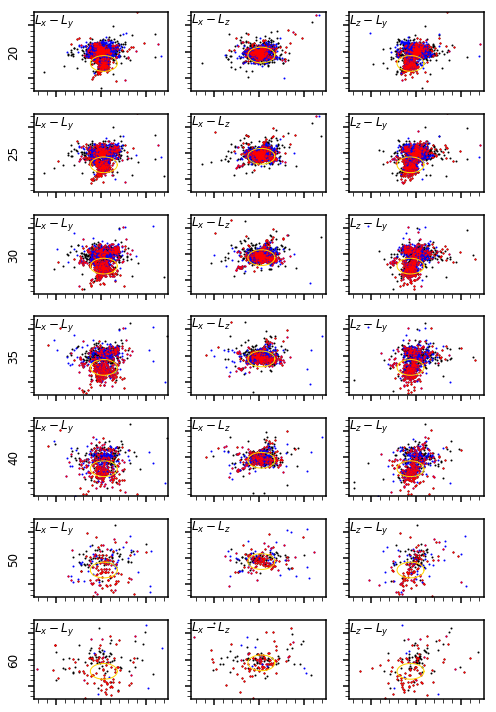

In [6]:

fig = plt.figure(figsize=(7,10))

minvals = [20,25,30,35,40,50,60]
maxvals = [30,35,40,45,50,60,150]

for indx in range(0,7):
    ax1 = fig.add_subplot(7,3,indx*3 + 1)
    ax2 = fig.add_subplot(7,3,indx*3 + 2)
    ax3 = fig.add_subplot(7,3,indx*3 + 3)
    
    dmin = minvals[indx]
    dmax = maxvals[indx]

    In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
    In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiant_edr3_metal.txt',skip_header=1)
    Lx,Ly,Lz = return_angular_momentum(In)
    d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] +In[:,2]*In[:,2] )
    dlimits = (d>dmin) & (d<dmax)

    ax1.scatter(Lx[dlimits],Ly[dlimits],color='black',s=1.)
    ax2.scatter(Lx[dlimits],Lz[dlimits],color='black',s=1.)
    ax3.scatter(Lz[dlimits],Ly[dlimits],color='black',s=1.)

    dlimits = (d>dmin) & (d<dmax) & (np.abs(In[:,20])<10) & (np.abs(In[:,6])>20)

    ax1.scatter(Lx[dlimits],Ly[dlimits],color='red',s=1.)
    ax2.scatter(Lx[dlimits],Lz[dlimits],color='red',s=1.)
    ax3.scatter(Lz[dlimits],Ly[dlimits],color='red',s=1.)
    
    In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
    In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHB_edr3_metal_superclean.txt',skip_header=1)
    Lx,Ly,Lz = return_angular_momentum(In)
    d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] +In[:,2]*In[:,2] )
    dlimits = (d>dmin) & (d<dmax)
    ax1.scatter(Lx[dlimits],Ly[dlimits],color='blue',s=1.)
    ax2.scatter(Lx[dlimits],Lz[dlimits],color='blue',s=1.)
    ax3.scatter(Lz[dlimits],Ly[dlimits],color='blue',s=1.)
    
    dlimits = (d>dmin) & (d<dmax) & (np.abs(In[:,20])<10) & (np.abs(In[:,6])>20)

    ax1.scatter(Lx[dlimits],Ly[dlimits],color='red',s=1.)
    ax2.scatter(Lx[dlimits],Lz[dlimits],color='red',s=1.)
    ax3.scatter(Lz[dlimits],Ly[dlimits],color='red',s=1.)    
    
    circlerad = 3000
    circlevals = np.linspace(0.,2*np.pi,100)
    sgrvals = [605, -4515, -1267]
    ax1.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)
    ax2.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[2],color='gold',lw=1.)
    ax3.plot(circlerad*np.cos(circlevals)+sgrvals[2],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)




    for iax,ax in enumerate([ax1,ax2,ax3]):
        maxval = 15000
        ax.axis([-maxval,maxval,-maxval,maxval])
        ax.set_xticklabels(())
        ax.set_yticklabels(())
    ax1.set_ylabel(dmin,size=12)
    ax1.text(-maxval,maxval,'$L_x-L_y$',size=12,ha='left',va='top')
    ax2.text(-maxval,maxval,'$L_x-L_z$',size=12,ha='left',va='top')
    ax3.text(-maxval,maxval,'$L_z-L_y$',size=12,ha='left',va='top')
    
    
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/sgrcuts.png',dpi=300)

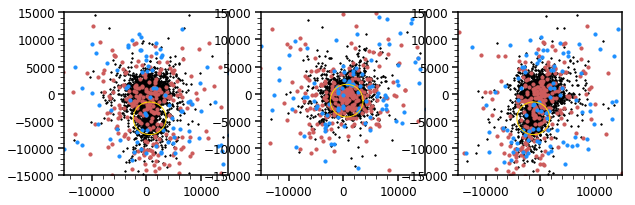

In [5]:




fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]

ax1.scatter(Lx,Ly,color='black',s=1.)
ax2.scatter(Lx,Lz,color='black',s=1.)
ax3.scatter(Lz,Ly,color='black',s=1.)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
ax1.scatter(Lx,Ly,color='black',s=1.)
ax2.scatter(Lx,Lz,color='black',s=1.)
ax3.scatter(Lz,Ly,color='black',s=1.)


In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]
d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])


dlim = 50
ax1.scatter(Lx[d>dlim],Ly[d>dlim],color='indianred',s=10.)
ax2.scatter(Lx[d>dlim],Lz[d>dlim],color='indianred',s=10.)
ax3.scatter(Lz[d>dlim],Ly[d>dlim],color='indianred',s=10.)



In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]
d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])



dlim = 50
ax1.scatter(Lx[d>dlim],Ly[d>dlim],color='dodgerblue',s=10.)
ax2.scatter(Lx[d>dlim],Lz[d>dlim],color='dodgerblue',s=10.)
ax3.scatter(Lz[d>dlim],Ly[d>dlim],color='dodgerblue',s=10.)


circlerad = 3000
circlevals = np.linspace(0.,2*np.pi,100)
sgrvals = [605, -4515, -1267]
ax1.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)
ax2.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[2],color='gold',lw=1.)
ax3.plot(circlerad*np.cos(circlevals)+sgrvals[2],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)

#circlerad = 5000
#circlevals = np.linspace(0.,2*np.pi,100)
#sgrvals = [-605, 4515, -1267]
#ax1.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)
#ax2.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[2],color='gold',lw=1.)
#ax3.plot(circlerad*np.cos(circlevals)+sgrvals[2],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)





for iax,ax in enumerate([ax1,ax2,ax3]):
    maxval = 15000
    ax.axis([-maxval,maxval,-maxval,maxval])

    
plt.savefig('figures/sgr_test_50_kpc.png')



# 605, -4515, 1267

In [6]:

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_corr.txt',skip_header=1)
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dlim = 40.
lzlim = 5000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]


larger_than_40 = np.where(d>dlim)[0]

print(larger_than_40.size)

sgr_larger_than_40 = np.where((d>dlim) & (ldiff<lzlim) & (np.abs(In[:,20])<20))[0]



print(sgr_larger_than_40.size)

print(larger_than_40.size-sgr_larger_than_40.size)



320
52
268


In [7]:
import reflexmotion.reflex as rm

In [8]:
r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)



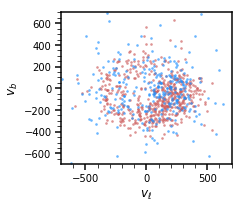

In [9]:
fig = plt.figure(figsize=(3.5,3))

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_corr.txt',skip_header=1)
#In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par

dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par



dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]


r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

plt.scatter(vl[nonsgr_larger_than_40],vb[nonsgr_larger_than_40],color='indianred',s=3.,alpha=0.5)


# BHBs
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par

dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par


dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]


r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

plt.scatter(vl[nonsgr_larger_than_40],vb[nonsgr_larger_than_40],color='dodgerblue',s=3.,alpha=0.5)

plt.axis([-4000,4000,-4000,4000])
plt.axis([-700,700,-700,700])


plt.xlabel('$v_\ell$',size=12)
plt.ylabel('$v_b$',size=12)

plt.tight_layout()
plt.savefig('figures/tangential_velocities_700.png',dpi=300)



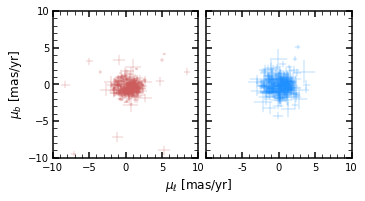

In [10]:
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.subplots_adjust(wspace=0.05,bottom=0.2,left=0.15,right=0.98)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_corr.txt',skip_header=1)
#In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par

dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par



dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]


r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

#plt.scatter(dmul[nonsgr_larger_than_40],dmub[nonsgr_larger_than_40],color='indianred',s=3.,alpha=0.5)
for indx in nonsgr_larger_than_40:
    #print(In[indx,14],dmul[indx])
    ax1.plot([dmul[indx]-In[indx,14],dmul[indx]+In[indx,14]],[dmub[indx],dmub[indx]],color='indianred',lw=.3)
    ax1.plot([dmul[indx],dmul[indx]],[dmub[indx]-In[indx,15],dmub[indx]+In[indx,15]],color='indianred',lw=0.3)




# BHBs
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par

dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par


dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]


r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

#plt.scatter(dmul[nonsgr_larger_than_40],dmub[nonsgr_larger_than_40],color='dodgerblue',s=3.,alpha=0.5)

for indx in nonsgr_larger_than_40:
    #print(In[indx,14],dmul[indx])
    ax2.plot([dmul[indx]-In[indx,14],dmul[indx]+In[indx,14]],[dmub[indx],dmub[indx]],color='dodgerblue',lw=.3)
    ax2.plot([dmul[indx],dmul[indx]],[dmub[indx]-In[indx,15],dmub[indx]+In[indx,15]],color='dodgerblue',lw=0.3)



#plt.axis([-4000,4000,-4000,4000])
ax1.axis([-10,10,-10,10])
ax2.axis([-10,10,-10,10])



ax1.set_xlabel("$\mu_\ell$ [mas/yr]",size=12,x=1)
ax1.set_ylabel("$\mu_b$ [mas/yr]",size=12)

ax2.set_yticklabels(())

for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

ax2.set_xticklabels(['','-5','0','5','10'])

#plt.tight_layout()
plt.savefig('figures/tangential_propermotion.png',dpi=300)




In [11]:
InC = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_d040150_sgr20_l3000_corr.txt2')

dvals = InC[:,0]
xmul  = InC[:,4]

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_corr.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
Lx,Ly,Lz = return_angular_momentum(In)


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par
evl = (dmul+In[:,14])*dk/par - vl


dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par
evb  = (dmub+In[:,15])*dk/par - vb




dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]
print(nonsgr_larger_than_40.size)

checknum = 0
invalidK = []
for indx,i in enumerate(nonsgr_larger_than_40):
    check1 = np.where((np.abs(rad[i]-dvals) <= 0.04) & (np.abs(dmul[i]-xmul) <= 0.01))[0]
    #print(indx,checknum,check1)
    if checknum in check1:
        #print(checknum)
        checknum+=1
    else:
        print('INVALID')
        invalidK.append(i)
            
print(len(invalidK))         
    #check2 = np.where(np.abs(dmul[i]-xmul) <= 0.02)
    #print(check1,check2)
    #if check1 != check2:
        #print(dist[i],dvals[check1],dmul[i],xmul[check2])
        #print(check1,check2)
    
    #print(d,dvals[np.nanargmin(np.abs(d-dvals))])


562
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
19


In [12]:
InC = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_d040150_sgr20_l3000_lanc_corr.txt2')

dvals = InC[:,0]
xmul  = InC[:,4]

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par
evl = (dmul+In[:,14])*dk/par - vl


dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par
evb  = (dmub+In[:,15])*dk/par - vb




dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]
print(nonsgr_larger_than_40.size)

checknum = 0
invalidB = []
for indx,i in enumerate(nonsgr_larger_than_40):
    #print(dist[i],dvals[0:10])
    check1 = np.where((np.abs(rad[i]-dvals) <= 0.05) & (np.abs(dmul[i]-xmul) <= 0.02))[0]
    #print(indx,checknum,check1)
    if checknum in check1:
        #print(checknum)
        checknum+=1
    else:
        print('INVALID')
        invalidB.append(i)
            
print(len(invalidB))         
    #check2 = np.where(np.abs(dmul[i]-xmul) <= 0.02)
    #print(check1,check2)
    #if check1 != check2:
        #print(dist[i],dvals[check1],dmul[i],xmul[check2])
        #print(check1,check2)
    
    #print(d,dvals[np.nanargmin(np.abs(d-dvals))])



300
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
8


562
24
300
41


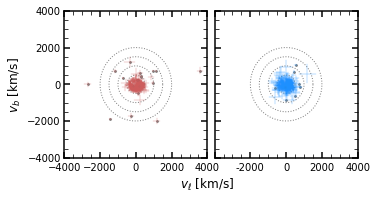

In [14]:
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.subplots_adjust(wspace=0.05,bottom=0.2,left=0.15,right=0.965)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_corr.txt',skip_header=1)


Lx,Ly,Lz = return_angular_momentum(In)


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par
evl = (dmul+In[:,14])*dk/par - vl


dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par
evb  = (dmub+In[:,15])*dk/par - vb




dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]
print(nonsgr_larger_than_40.size)

tanvel = np.sqrt(vl*vl + vb*vb)[nonsgr_larger_than_40]
largevel = np.where(tanvel>500.)[0]
print(largevel.size)
#r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

#plt.scatter(dmul[nonsgr_larger_than_40],dmub[nonsgr_larger_than_40],color='indianred',s=3.,alpha=0.5)
for indx in nonsgr_larger_than_40:
    #print(In[indx,14],dmul[indx])
    ax1.plot([vl[indx]-evl[indx],vl[indx]+evl[indx]],[vb[indx],vb[indx]],color='indianred',lw=.3)
    ax1.plot([vl[indx],vl[indx]],[vb[indx]-evb[indx],vb[indx]+evb[indx]],color='indianred',lw=0.3)

ax1.scatter(vl[invalidK],vb[invalidK],color='grey',s=3.,marker='o')





# BHBs
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr_lancasterremoved.txt',skip_header=1)




Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


d = np.sqrt(In[:,0]*In[:,0] + In[:,1]*In[:,1] + In[:,2]*In[:,2])

dmul = In[:,10]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vl = dmul*dk/par
evl = (dmul+In[:,14])*dk/par - vl

dmub = In[:,11]
rad = In[:,8]
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
vb = dmub*dk/par
evb  = (dmub+In[:,15])*dk/par - vb

dlim = 40.
lzlim = 3000.
sgrvals = [605., -4515., -1267.]

ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)
nonsgr_larger_than_40 = np.where((d>dlim) & ((ldiff>lzlim) | (np.abs(In[:,20])>20)))[0]
print(nonsgr_larger_than_40.size)

tanvel = np.sqrt(vl*vl + vb*vb)[nonsgr_larger_than_40]
largevel = np.where(tanvel>500.)[0]
print(largevel.size)

#r,theta,phi,vr,vtheta,vphi = rm.compute_spherical(In[:,0],In[:,1],In[:,2],In[:,3],In[:,4],In[:,5],twopi=True)

for indx in nonsgr_larger_than_40:
    ax2.plot([vl[indx]-evl[indx],vl[indx]+evl[indx]],[vb[indx],vb[indx]],color='dodgerblue',lw=.3)
    ax2.plot([vl[indx],vl[indx]],[vb[indx]-evb[indx],vb[indx]+evb[indx]],color='dodgerblue',lw=0.3)

ax2.scatter(vl[invalidB],vb[invalidB],color='grey',s=3.,marker='o')

ax1.axis([-4000,4000,-4000,4000])
ax2.axis([-4000,4000,-4000,4000])

phi = np.linspace(0.,2.*np.pi,200)
for rad in [500,1000,1500,2000]:
    ax2.plot(rad*np.cos(phi),rad*np.sin(phi),color='grey',zorder=-10,lw=1.,linestyle='dotted')
    ax1.plot(rad*np.cos(phi),rad*np.sin(phi),color='grey',zorder=-10,lw=1.,linestyle='dotted')


ax1.set_xlabel("$v_\ell$ [km/s]",size=12,x=1)
ax1.set_ylabel("$v_b$ [km/s]",size=12)

ax2.set_yticklabels(())

for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

ax2.set_xticklabels(['','-2000','0','2000','4000'])

#plt.tight_layout()
plt.savefig('figures/tangential_velocity.png',dpi=300)



